# Predict the classification and create risk profile


## Summary

### Group 2:
  Chao Xu,  Weichuan Xu,  Sanket Harinarayan Khandelwal, Pooja Swaminathan


### Objectives:
For this project, first, we want to use the machine learning model to predict the classification to replace the job finished by analyst before. Second, we want to create the risk profile based on our models

### Methods:
Classification problem: Logistic Regression &  Random Forest models

### Introduction
For predicting the classification, we want to minimize the FP, so we encoding the FP as 1, and others as 0. 
For create risk profile, we encoding all classification value which risk involved (TP/Low, TP/High) as 1, and others as 0.
In this notebook, we use the feature importance to create the risk profile, from the result we can see **score**, **risk_factor**, **APP_2_DWB** are top 3 most important features, which can give suggestion to GE Aviation to pay more attention on that.

From the result, we can see that our model's performance is pretty good, the best model is Random Forest, the accuracy is: **0.989**, the precision is: **0.929**, the recall is: **0.742**.

## Content



<a href="#Part 1: DataExploration">[Part 1: Data Exploration]
  
<a href="#Part-2:-Feature-Preprocessing">[Part 2: Feature Preprocessing]
  
<a href="#Part-3:-Model-Training-and-Result-Evaluation">[Part 3: Model Training and Results Evaluation]

<a href="#Part-4:-Feature-Selection">[Part 4: Feature Selection]



## Workflow
![workflow](https://raw.githubusercontent.com/amueller/ml-workshop-2-of-4/master/slides/images/gridsearch_workflow.png )

# Part 0: Load the data set

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# load the alert dataset
file_id='1MjqZCt49ttsJBmKPjYZI-1T5BFrF7JXa'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url=link.format(FILE_ID=file_id)
my_data = pd.read_csv(csv_url)

# load the demographic dataset
file_id2 ='1rQwrS3iYEw1W92jlpMvpR-MYQyRuN93m'
csv_url2 = link.format(FILE_ID=file_id2)
demographic = pd.read_csv(csv_url2)

data description

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

import imblearn
# will show all the columns
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
print('total number of rows in alert dataset: %d' % my_data.shape[0])
print('total number of rows in demographic dataset: %d' % demographic.shape[0])

total number of rows in alert dataset: 127710
total number of rows in demographic dataset: 1374


In [4]:
my_data.head()

,type_name,alert_escalation_date,alert_id_fk,insert_date,score,status,resolution,owner_name,malicious,employee_id,risk_factor,avg_score,classification,HRU,indicators,indicator_pairs,alert_category,alert_type,grouping,indicator_heat_score
0,TP,3/26/2018 20:18,319529787,9/29/2017,180,cleared,closed,Senior_Analyst_1,yes,2313834724,1.800,100.000,TP/DE,None,App_1_Box_Aged_Files,App_1_Box_Aged_Files,Heat,Daily_Heat,App_1,3.000
1,TP,3/26/2018 20:18,1633242574,9/29/2017,172,cleared,closed,Senior_Analyst_1,yes,13152813815,1.720,100.000,TP/DE,HRU11,App_1_Box_Aged_Files,App_1_Box_Aged_Files/App_4_Request_Volume_30da...,Heat,Daily_Heat,App_1,3.000
2,TP,3/26/2018 20:18,1633242574,9/29/2017,172,cleared,closed,Senior_Analyst_1,yes,13152813815,1.720,100.000,TP/DE,HRU11,App_4_Request_Volume_30day,App_1_Box_Aged_Files/App_4_Request_Volume_30da...,Heat,Daily_Heat,App_4,4.000
3,TP,3/26/2018 20:18,1633242574,9/29/2017,172,cleared,closed,Senior_Analyst_1,yes,13152813815,1.720,100.000,TP/DE,HRU11,App_4_Request_Volume_90day,App_1_Box_Aged_Files/App_4_Request_Volume_30da...,Heat,Daily_Heat,App_4,3.000
4,TP,3/26/2018 20:18,1633242574,9/29/2017,172,cleared,closed,Senior_Analyst_1,yes,13152813815,1.720,100.000,TP/DE,HRU11,App_14_Threshold_1,App_1_Box_Aged_Files/App_4_Request_Volume_30da...,Heat,Daily_Heat,App_14,3.000


In [5]:
my_data.owner_name.value_counts()

Senior_Analyst_1    69728
Analyst_4           33081
Analyst_1           10629
Analyst_6            9283
Senior_Analyst_2     4490
Analyst_5             275
Analyst_3             214
Analyst_2              10
Name: owner_name, dtype: int64

In [6]:
demographic.head()

,employee_id,Person_Type,GE_Hire_Date,State_Name,Country_Name,COUNTRY_CODE,Business_Segment,Sub_Business,Function,Function_Group,Org_Name,Career_Band,JOB_TITLE,JOB_TYPE
0,7296648307,Employee,6/27/2010 0:00,Dubai,United Arab Emirates,AE,Aviation Commercial Engines,AVI CEO-Customer & Product Support,Engineering/Technology,Production,AVI CEO-CPS-Commercial Field Service,SPB,No_Data,Sr Engineering Manager 2 - Fleet Management
1,9526104533,Ex-employee,11/8/2010 0:00,Karnataka,India,IN,Aviation Digital,AVI DIG-Digital Service Solutions,Digital Technology,Enabling,AVI DIG-DSS-India,SPB,No_Data,Sr Staff Data Scientist
2,3655799847,Employee,8/27/2007 0:00,Masovian,Poland,PL,Aviation Engineering,AVI ENG-Engineering Design Center Poland,Engineering/Technology,Production,AVI ENG-EDC-Engineering Material Systems,SPB,No_Data,Sr Scientist CTH 3 - Materials Science and Eng...
3,9672758310,Employee,4/22/1996 0:00,Ohio,United States,US,Aviation Engineering,AVI ENG-Engineering Material Systems,Engineering/Technology,Production,AVI ENG-Engineering Material Systems,SPB,No_Data,Sr Scientist 1 - Materials Science and Enginee...
4,13558590425,Employee,2/3/1997 0:00,Ohio,United States,US,Aviation Engineering,AVI ENG-Chief Engineer,Engineering/Technology,Production,AVI ENG-CE-General Electric Aviation Engines,SPB,No_Data,Sr Engineer CTH 0 - Chief Engineering


#### drop the meaningless columns

In [7]:
# Drop the features that assigned by data scientist
df_indicator = my_data['indicators'].copy()
assign_ds = ['type_name', 'indicators', 'alert_category', 'grouping','indicator_heat_score']
my_data = my_data.drop(assign_ds, axis=1)
print('Alert dataset:', '\n', "Dataset size: %d  number of features: %d  number of classes: %d"
      % (my_data.shape[0], my_data.shape[1], len(np.unique(my_data['classification']))))

Alert dataset: 
 Dataset size: 127710  number of features: 15  number of classes: 4


In [8]:
no_mean = ['Person_Type', 'GE_Hire_Date',
       'Country_Name', 'Sub_Business','Function', 'Org_Name',  
       'JOB_TITLE','JOB_TYPE']
demographic = demographic.drop(no_mean, axis=1)
print('Demographic dataset:', '\n',"Dataset size: %d  number of features: %d"
      % (demographic.shape[0], demographic.shape[1]))

Demographic dataset: 
 Dataset size: 1374  number of features: 6


In [9]:
# Check the duplicated data
my_data_dup = my_data[my_data.duplicated(keep='first')]
print('The number of duplicated data is: %d' % my_data_dup.shape[0])
demographic_dup = demographic[demographic.duplicated(keep='first')]
print('The number of duplicated data in demographic is: %d' % demographic_dup.shape[0])

The number of duplicated data is: 27239
The number of duplicated data in demographic is: 0


In [10]:
# Remove the duplicated data
my_data = my_data.drop_duplicates()
print('All duplicated data have been dropped')
print('The total number of rows: %d' % my_data.shape[0])

All duplicated data have been dropped
The total number of rows: 100471


In [11]:
new_data = pd.merge(my_data, demographic, on = 'employee_id')
new_data.head()

,alert_escalation_date,alert_id_fk,insert_date,score,status,resolution,owner_name,malicious,employee_id,risk_factor,avg_score,classification,HRU,indicator_pairs,alert_type,State_Name,COUNTRY_CODE,Business_Segment,Function_Group,Career_Band
0,3/26/2018 20:18,319529787,9/29/2017,180,cleared,closed,Senior_Analyst_1,yes,2313834724,1.800,100.000,TP/DE,None,App_1_Box_Aged_Files,Daily_Heat,Ohio,US,Aviation Supply Chain,Production,SPB
1,3/26/2018 20:18,1393818439,9/29/2017,195,cleared,closed,Senior_Analyst_1,yes,2313834724,1.950,100.000,TP/DE,None,App_1_Box_Aged_Files,Daily_Heat,Ohio,US,Aviation Supply Chain,Production,SPB
2,3/26/2018 20:18,625554667,9/29/2017,174,cleared,closed,Senior_Analyst_1,yes,2313834724,1.740,100.000,TP/DE,None,App_1_Box_Aged_Files,Daily_Heat,Ohio,US,Aviation Supply Chain,Production,SPB
3,3/26/2018 20:18,1633242574,9/29/2017,172,cleared,closed,Senior_Analyst_1,yes,13152813815,1.720,100.000,TP/DE,HRU11,App_1_Box_Aged_Files/App_4_Request_Volume_30da...,Daily_Heat,Ohio,US,Aviation Engineering,Production,LPB
4,3/26/2018 20:21,1025069746,10/19/2017,256,cleared,closed,Senior_Analyst_1,yes,13152813815,2.560,100.000,TP/DE,HRU11,App_1_Box_Aged_Files/App_4_Request_Volume_30da...,Daily_Heat,Ohio,US,Aviation Engineering,Production,LPB


### Part 1.2: Data cleaning

Find the missing value

In [12]:
new_data.isna().sum()[new_data.isna().sum() != 0]

risk_factor    83306
avg_score      83306
dtype: int64

In [13]:
new_data.alert_type.value_counts()

Atomic          83306
Daily_Heat       6067
Monthly_Heat     5544
Weekly_Heat      4546
Name: alert_type, dtype: int64

As looking through the dataset, the avg_score and risk_factor will be NA for atomic alerts (alert_type), so we can ues minimal value to fill those missing values

In [14]:
temp = my_data.loc[my_data['alert_type']!='Atomic']
for i in ['risk_factor', 'avg_score']:
  print(temp[i].describe(), '\n')

count   16914.000
mean        9.990
std        12.473
min         1.700
25%         2.927
50%         7.931
75%        11.567
max       629.645
Name: risk_factor, dtype: float64 

count    16914.000
mean       407.927
std       1777.487
min         90.000
25%        100.000
50%        110.000
75%        245.000
max     113727.000
Name: avg_score, dtype: float64 



In [ ]:
#fill the risk_factor and avg_score with min of each feature
new_data[['risk_factor']] = new_data[['risk_factor']].fillna(1.7)
new_data[['avg_score']] = new_data[['avg_score']].fillna(90)

In [16]:
print('Dataset:', '\n', "Dataset size: %d  number of features: %d  number of classes: %d"
      % (new_data.shape[0], new_data.shape[1], len(np.unique(new_data['classification']))))

Dataset: 
 Dataset size: 99463  number of features: 20  number of classes: 4


### Part 1.3:  Understand the features

#### Understand the numerical features

In [17]:
# Understand the numerical feature
print(my_data[['score', 'risk_factor', 'avg_score']].describe(percentiles = [.1, .25, .5, .75, .95]))

            score  risk_factor  avg_score
count  100471.000    16915.000  16915.000
mean      698.643        9.990    407.903
std      8622.462       12.473   1777.437
min         3.000        1.700      5.000
10%        10.000        2.000     90.000
25%        10.000        2.926    100.000
50%        10.000        7.930    110.000
75%        10.000       11.567    245.000
95%      1890.000       29.762   1178.000
max   1147968.000      629.645 113727.000


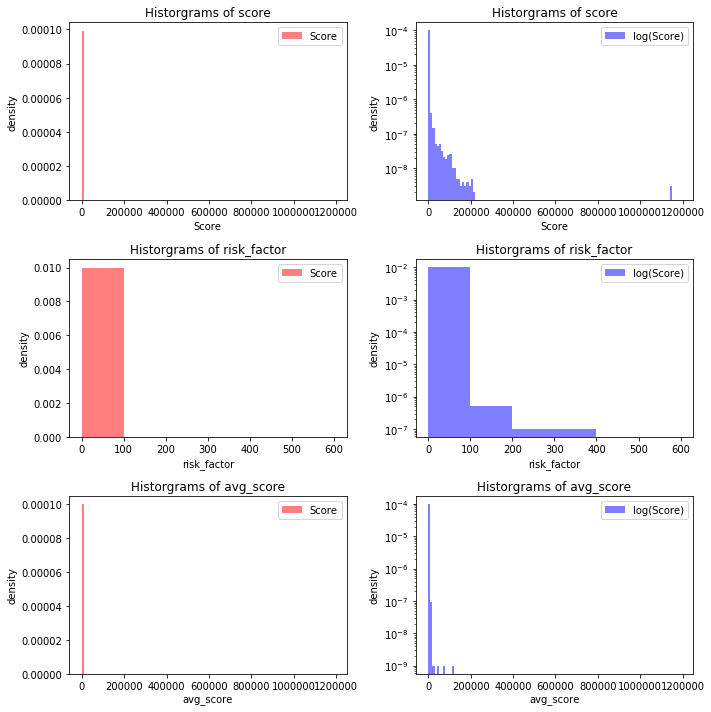

In [18]:
# check the feature distribution
fig, axes = plt.subplots(3,2,figsize=(10, 10))

# Score
axes[0, 0].hist(new_data['score'].values, bins=range(0, 1200000, 10000), alpha=0.5, color='r', label='Score', normed=True)
axes[0, 0].legend(loc='upper right')
axes[0, 0].set_title('Historgrams of score')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('density')

#log scale of score to the large variation
axes[0, 1].hist(new_data['score'].values, log=True, bins=range(0, 1200000, 10000), alpha=0.5, color='b', label='log(Score)', normed=True)
axes[0, 1].legend(loc='upper right')
axes[0, 1].set_title('Historgrams of score')
axes[0, 1].set_xlabel('Score')
axes[0, 1].set_ylabel('density')


# Risk_factor
axes[1, 0].hist(new_data['risk_factor'].values, bins=range(0, 700, 100), alpha=0.5, color='r', label='Score', normed=True)
axes[1, 0].legend(loc='upper right')
axes[1, 0].set_title('Historgrams of risk_factor')
axes[1, 0].set_xlabel('risk_factor')
axes[1, 0].set_ylabel('density')

#log scale of risk_factor to the large variation
axes[1, 1].hist(new_data['risk_factor'].values, log=True, bins=range(0, 700, 100), alpha=0.5, color='b', label='log(Score)', normed=True)
axes[1, 1].legend(loc='upper right')
axes[1, 1].set_title('Historgrams of risk_factor')
axes[1, 1].set_xlabel('risk_factor')
axes[1, 1].set_ylabel('density')

# Avg_score
axes[2, 0].hist(new_data['avg_score'].values, bins=range(0, 1200000, 10000), alpha=0.5, color='r', label='Score', normed=True)
axes[2, 0].legend(loc='upper right')
axes[2, 0].set_title('Historgrams of avg_score')
axes[2, 0].set_xlabel('avg_score')
axes[2, 0].set_ylabel('density')

#log scale of avg_score to the large variation
axes[2, 1].hist(new_data['avg_score'].values, log=True, bins=range(0, 1200000, 10000), alpha=0.5, color='b', label='log(Score)', normed=True)
axes[2, 1].legend(loc='upper right')
axes[2, 1].set_title('Historgrams of avg_score')
axes[2, 1].set_xlabel('avg_score')
axes[2, 1].set_ylabel('density')

plt.tight_layout()


#### Numerical features and categorical features

,score,risk_factor,avg_score,malicious_ord,classification_ord
score,1.000,0.210,0.893,0.021,0.014
risk_factor,0.210,1.000,0.090,0.137,0.177
avg_score,0.893,0.090,1.000,0.024,-0.002
malicious_ord,0.021,0.137,0.024,1.000,0.087
classification_ord,0.014,0.177,-0.002,0.087,1.000


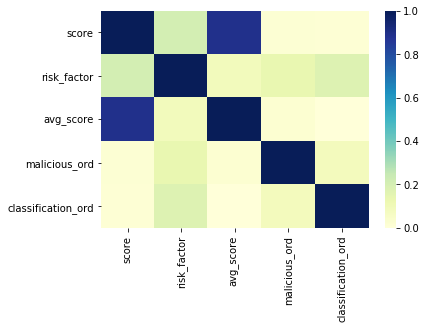

In [19]:
# corrleation of numerical features
## Encoding
new_data['malicious_ord'] = new_data.malicious.astype("category").cat.codes
new_data['classification_ord'] = np.where(new_data['classification'].isin(['FP', 'TP/DE']), 0, 1)
encoding_col = ['malicious', 'classification']
new_data = new_data.drop(encoding_col, axis=1)


corr = new_data[["score", "risk_factor", "avg_score", 
                "malicious_ord", "classification_ord"]].corr()

sns.heatmap(corr, cmap='YlGnBu')
corr

### HRU & Alert_type

In [ ]:
# plot the number of FP
def plot_number(col, rot=-45, num=None):
  group_by = pd.DataFrame(new_data.groupby([col])['classification_ord'].sum()).sort_values('classification_ord', ascending=False)
  if num:
    group_by = group_by[:num-1]
    sns.barplot(x=group_by.index, y='classification_ord', data=group_by, palette='Set2')
    plt.xticks(rotation=rot)
    plt.xlabel(col)
    plt.ylabel('The number of FP')
    plt.show()
  else:
    sns.barplot(x=group_by.index, y='classification_ord', data=group_by, palette='Set2')
    plt.xticks(rotation=rot)
    plt.xlabel(col)
    plt.ylabel('The number of FP')
    plt.show()

# plot the percentage
def plot_percentage(col, rot=-45, num=None):
  group_by = pd.DataFrame(new_data.groupby([col])['classification_ord'].sum()).sort_index()
  counts = pd.DataFrame(new_data[col].value_counts()).sort_index()
  total = pd.merge(counts, group_by, on=counts.index)
  total['percentage'] = total.apply(lambda x: x['classification_ord'] / x[col], axis=1)
  total = total.sort_values('percentage', ascending=False)
  if num:
    total = total[:num-1]
    sns.barplot(x='key_0', y='percentage', data=total, palette='Set2')
    plt.xticks(rotation=rot)
    plt.xlabel(col)
    plt.ylabel('The Percentage of FP')
    plt.show()
  else:
    sns.barplot(x='key_0', y='percentage', data=total, palette='Set2')
    plt.xticks(rotation=rot)
    plt.xlabel(col)
    plt.ylabel('The Percentage of FP')
    plt.show()

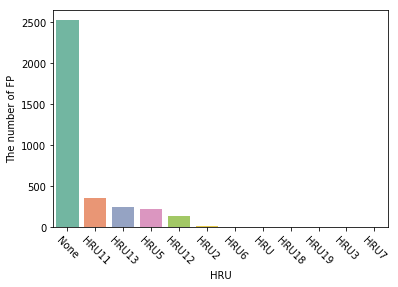

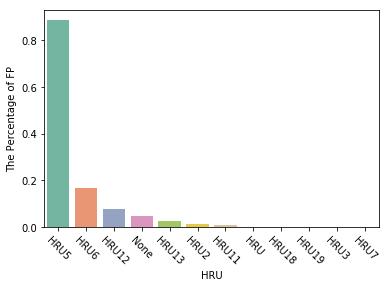

In [21]:
plot_number('HRU')
plot_percentage('HRU')

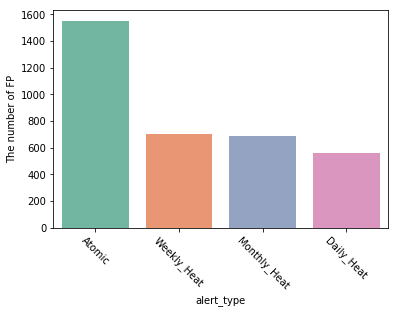

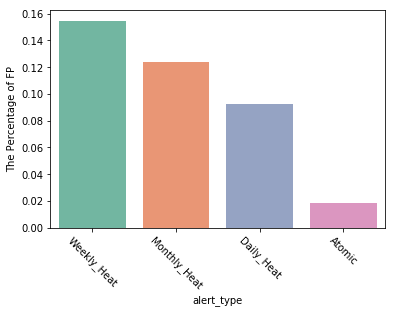

In [22]:
# alert type
plot_number('alert_type')
plot_percentage('alert_type')

### Country & State

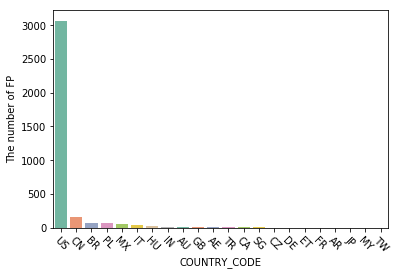

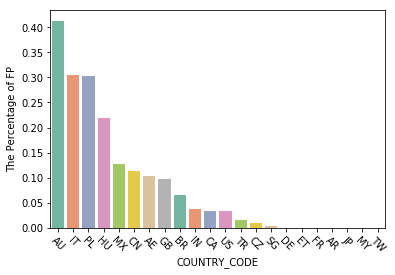

In [23]:
plot_number('COUNTRY_CODE')
plot_percentage('COUNTRY_CODE')


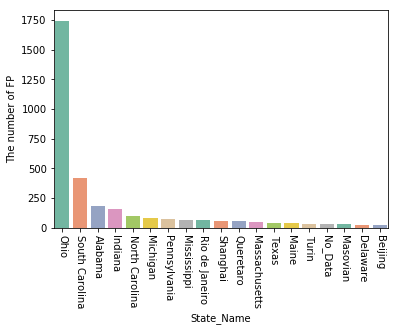

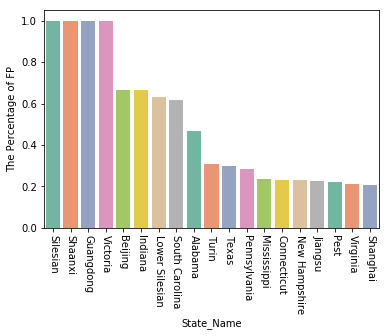

In [24]:
# State
plot_number('State_Name', -90, 20)
plot_percentage('State_Name', -90, 20)

### Business Segment

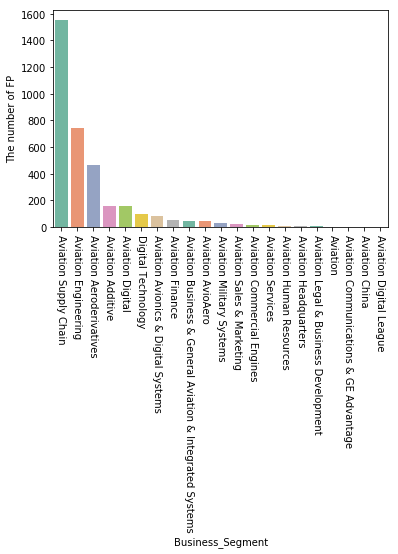

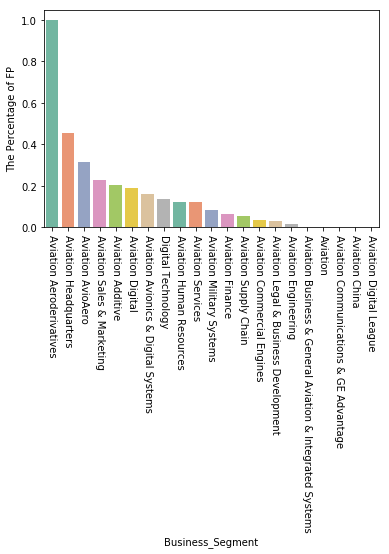

In [25]:
plot_number('Business_Segment', -90)
plot_percentage('Business_Segment', -90)

In [26]:
group_by_bs = pd.DataFrame(new_data.groupby(['Business_Segment'])['classification_ord'].sum()).sort_index()
counts = pd.DataFrame(new_data['Business_Segment'].value_counts()).sort_index()
total = pd.merge(counts, group_by_bs, on=counts.index)
total['percentage'] = total.apply(lambda x: x['classification_ord'] / x['Business_Segment'], axis=1)
total = total.sort_values('percentage', ascending=False)
total.loc[total['percentage'] >= 0.5]

,key_0,Business_Segment,classification_ord,percentage
2,Aviation Aeroderivatives,467,467,1.000


### Function_group & Career_band

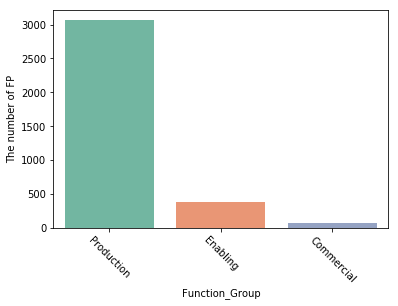

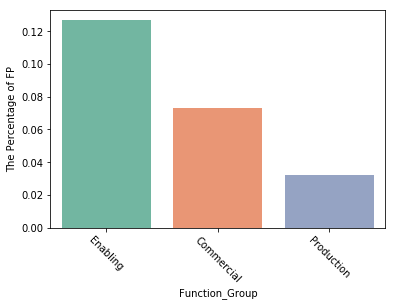

In [27]:
plot_number('Function_Group')
plot_percentage('Function_Group')

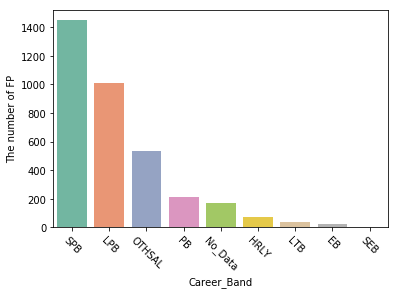

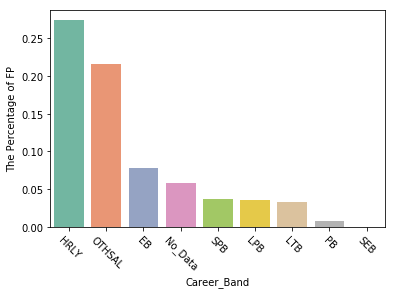

In [28]:
plot_number('Career_Band')
plot_percentage('Career_Band')

HB = Hourly Band

APB = Associate Professional Band

PB = Professional Band

LPB = Lead Professional Band

SPB = Senior Professional Band

EB = Executive Band

Salary differs so as benififits according to your band.

GE offers good salary packages and benefits.

### Employee_id

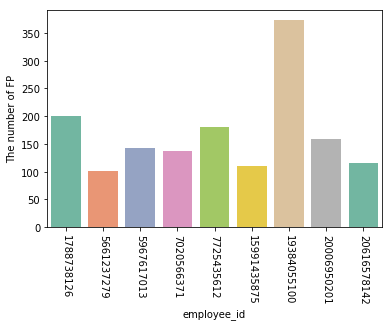

In [29]:
plot_number('employee_id', -90, 10)

# Part 2: Feature Preprocessing

In [30]:
new_data.dtypes

alert_escalation_date     object
alert_id_fk                int64
insert_date               object
score                      int64
status                    object
resolution                object
owner_name                object
employee_id                int64
risk_factor              float64
avg_score                float64
HRU                       object
indicator_pairs           object
alert_type                object
State_Name                object
COUNTRY_CODE              object
Business_Segment          object
Function_Group            object
Career_Band               object
malicious_ord               int8
classification_ord         int64
dtype: object

In [ ]:
# Drop some useless columns
to_drop = ['employee_id', 'alert_escalation_date', 'alert_id_fk', 'insert_date',
           'status', 'resolution', 'owner_name', 'avg_score',
]
my_data_prep = new_data.drop(to_drop, axis=1)

In [32]:
my_data_prep.dtypes

score                   int64
risk_factor           float64
HRU                    object
indicator_pairs        object
alert_type             object
State_Name             object
COUNTRY_CODE           object
Business_Segment       object
Function_Group         object
Career_Band            object
malicious_ord            int8
classification_ord      int64
dtype: object

In [ ]:
# Covert indiactor_pairs into dummy variables
indicators = df_indicator.unique().tolist()
d_indicators = pd.DataFrame()
for ind in indicators:
  ind_list = []
  for i in range(my_data_prep.shape[0]):
    if ind in my_data_prep['indicator_pairs'].iloc[i]:
      ind_list.append(1)
    else:
      ind_list.append(0)
  d_indicators[ind] = pd.Series(ind_list).values


In [ ]:
new_data = my_data_prep.drop(['indicator_pairs'], axis=1)
X = new_data.drop("classification_ord", axis=1)
y = new_data['classification_ord']

In [ ]:
X = pd.get_dummies(X, columns=['HRU', 'alert_type',
       'State_Name', 'COUNTRY_CODE', 'Business_Segment', 'Function_Group',
       'Career_Band'])


In [ ]:
# scaling and encoding
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric = ['score']
ct = make_column_transformer((StandardScaler(), numeric))

In [ ]:
scaler_score = pd.DataFrame(ct.fit_transform(X), columns=['score'])

In [38]:
X['score'] = scaler_score
X.head()

,score,risk_factor,malicious_ord,HRU_HRU,HRU_HRU11,HRU_HRU12,HRU_HRU13,HRU_HRU18,HRU_HRU19,HRU_HRU2,HRU_HRU3,HRU_HRU5,HRU_HRU6,HRU_HRU7,HRU_None,alert_type_Atomic,alert_type_Daily_Heat,alert_type_Monthly_Heat,alert_type_Weekly_Heat,State_Name_Abu Dhabi,State_Name_Addis Ababa,State_Name_Alabama,State_Name_Alberta,State_Name_Arizona,State_Name_Bavaria,State_Name_Beijing,State_Name_Brindisi,State_Name_California,State_Name_Ceara,State_Name_Central Singapore,State_Name_Ciudad Autonoma de Buenos Aires,State_Name_Coahuila,State_Name_Colorado,State_Name_Connecticut,State_Name_Delaware,State_Name_District Of Columbia,State_Name_Dubai,State_Name_England,State_Name_Florida,State_Name_Georgia,State_Name_Guangdong,State_Name_Hainan,State_Name_Haryana,State_Name_Ile-de-France,State_Name_Illinois,State_Name_Indiana,State_Name_Iowa,State_Name_Jiangsu,State_Name_Kansas,State_Name_Karnataka,State_Name_Kentucky,State_Name_Kocaeli,State_Name_Louisiana,State_Name_Lower Silesian,State_Name_Maharashtra,State_Name_Maine,State_Name_Maryland,State_Name_Masovian,State_Name_Massachusetts,State_Name_Michigan,State_Name_Mississippi,State_Name_New Hampshire,State_Name_New South Wales,State_Name_New York,State_Name_No_Data,State_Name_North Carolina,State_Name_Nova Scotia,State_Name_Ohio,State_Name_Oklahoma,State_Name_Pennsylvania,State_Name_Pest,State_Name_Prague,State_Name_Quebec,State_Name_Queensland,State_Name_Queretaro,State_Name_Rio de Janeiro,State_Name_Sao Paulo,State_Name_Scotland,State_Name_Selangor,State_Name_Shaanxi,State_Name_Shandong,State_Name_Shanghai,State_Name_Silesian,State_Name_South Carolina,State_Name_Taoyuan,State_Name_Texas,State_Name_Tokyo,State_Name_Turin,State_Name_Vermont,State_Name_Victoria,State_Name_Virginia,State_Name_Wales,State_Name_Washington,COUNTRY_CODE_AE,COUNTRY_CODE_AR,COUNTRY_CODE_AU,COUNTRY_CODE_BR,COUNTRY_CODE_CA,COUNTRY_CODE_CN,COUNTRY_CODE_CZ,COUNTRY_CODE_DE,COUNTRY_CODE_ET,COUNTRY_CODE_FR,COUNTRY_CODE_GB,COUNTRY_CODE_HU,COUNTRY_CODE_IN,COUNTRY_CODE_IT,COUNTRY_CODE_JP,COUNTRY_CODE_MX,COUNTRY_CODE_MY,COUNTRY_CODE_PL,COUNTRY_CODE_SG,COUNTRY_CODE_TR,COUNTRY_CODE_TW,COUNTRY_CODE_US,Business_Segment_Aviation,Business_Segment_Aviation Additive,Business_Segment_Aviation Aeroderivatives,Business_Segment_Aviation AvioAero,Business_Segment_Aviation Avionics & Digital Systems,Business_Segment_Aviation Business & General Aviation & Integrated Systems,Business_Segment_Aviation China,Business_Segment_Aviation Commercial Engines,Business_Segment_Aviation Communications & GE Advantage,Business_Segment_Aviation Digital,Business_Segment_Aviation Digital League,Business_Segment_Aviation Engineering,Business_Segment_Aviation Finance,Business_Segment_Aviation Headquarters,Business_Segment_Aviation Human Resources,Business_Segment_Aviation Legal & Business Development,Business_Segment_Aviation Military Systems,Business_Segment_Aviation Sales & Marketing,Business_Segment_Aviation Services,Business_Segment_Aviation Supply Chain,Business_Segment_Digital Technology,Function_Group_Commercial,Function_Group_Enabling,Function_Group_Production,Career_Band_EB,Career_Band_HRLY,Career_Band_LPB,Career_Band_LTB,Career_Band_No_Data,Career_Band_OTHSAL,Career_Band_PB,Career_Band_SEB,Career_Band_SPB
0,-0.054,1.800,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,-0.052,1.950,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,-0.055,1.740,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

In [ ]:
X = pd.concat([X, d_indicators], axis = 1)

In [40]:
print("Dataset size: %d  number of features: %d  number of classes: %d"
      % (X.shape[0], X.shape[1], len(np.unique(y))))

Dataset size: 99463  number of features: 242  number of classes: 2


# Part 3: Model Training and Result Evaluation

### Part 3.1: Split dataset

In [41]:
# Splite data into training and testing
from sklearn import model_selection

# stratifed sampling
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify = y)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 74597 observation with 242 features
test data has 24866 observation with 242 features


### Part 3.2: Model Training and Selection

In [ ]:
# build models
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# Random Forest
classifier_RF = RandomForestClassifier()

### Part 3.3: Use Grid Search to Find Optimal Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

#### Part 3.3.1: Find Optimal Hyperparameters - LogisticRegression

In [44]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': (5, 10), 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [45]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.979
Best parameters set:
	C: 10
	penalty: 'l2'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

#### Part 3.3.2: Find Optimal Hyperparameters: Random Forest

In [47]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [48]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.989
Best parameters set:
	n_estimators: 60


In [ ]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

### Part 3.4: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

class of interest as positive

TP: correctly labeled classification

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive classification divided by the total number of predictive classification;
High Precision means low fp.


Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive classification correctly. High recall means low fn.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['FP','TP']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Blues'))
        plt.title('Confusion matrix for %s \n' % classifier )
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.989
precision is: 0.929
recall is: 0.742


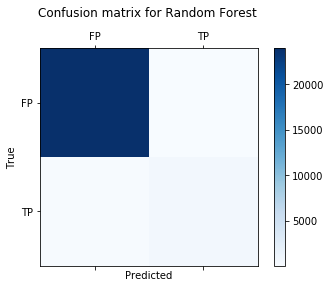

Logistic Regression
Accuracy is: 0.980
precision is: 0.829
recall is: 0.548


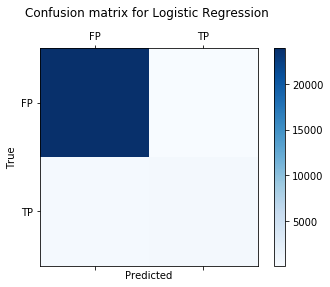

In [51]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
]

draw_confusion_matrices(confusion_matrices)

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 



In [52]:
# add L1 regularization to logistic regression
# check the coef for feature selection
LRmodel_l1 = LogisticRegression(penalty="l1", C = 0.1)
LRmodel_l1.fit(X, y)
LRmodel_l1.coef_[0]
print ("Logistic Regression (L1) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      X.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))

Logistic Regression (L1) Coefficients
App_2_DWB: 4.2935
App_21_Email_Recipient: 4.0944
App_2_DVD-Burn: -3.7467
State_Name_Indiana: 3.1492
State_Name_South Carolina: 2.8332
App_3_To_CDBurn: 2.2513
App_1_Box_Aged_Files: -1.9951
App_2_To_USB: 1.7635
App_15_Request_90day: -1.683
Badge_Rejection_Distinct_Locations_Threshold_7day: 1.6766
Career_Band_OTHSAL: 1.5591
State_Name_North Carolina: -1.5051
App_11_To_USB: 1.4703
HRU_HRU19: -1.3685
Business_Segment_Aviation Aeroderivatives: 1.262
State_Name_Pennsylvania: 1.256
App_8_Threshold_90day: -1.2203
State_Name_Massachusetts: -1.171
App_13_Website_Visit: -1.1453
App_3_To_Internet_upload: -1.1112
COUNTRY_CODE_SG: -0.9938
Top_Users_That_Egressed_Files_To_USB: 0.9445
App_2_To_Box: 0.909
HRU_HRU12: -0.9085
score: -0.8966
HRU_HRU5: 0.891
State_Name_Mississippi: 0.8696
State_Name_Florida: -0.8266
App_1_USB_Aged_Files: -0.7985
State_Name_Alabama: 0.7901
App_2_Access_Volume_7day: -0.7835
Business_Segment_Aviation Commercial Engines: -0.7818
COUNTRY_COD

In [53]:
# add L2 regularization to logistic regression
# check the coef for feature selection
LRmodel_l2 = LogisticRegression(penalty="l2", C = 5)
LRmodel_l2.fit(X, y)
LRmodel_l2.coef_[0]
print ("Logistic Regression (L2) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l2.coef_[0]), \
                      X.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))

Logistic Regression (L2) Coefficients
App_21_Email_Recipient: 7.1846
App_15_Request_90day: -5.7153
App_11_To_Box: -4.9784
State_Name_Lower Silesian: 4.4896
App_2_Reject_Volume_90day: 4.4827
HRU_HRU5: 4.4452
Business_Segment_Aviation Headquarters: -4.3963
State_Name_Indiana: 4.3738
HRU_HRU19: -4.2492
State_Name_South Carolina: 3.9704
App_2_DWB: 3.9547
Business_Segment_Aviation Aeroderivatives: 3.9547
Badge_Rejection_Distinct_Locations_Threshold_7day: 3.7745
Badge_Rejection_Expired_Badge_New_System: 3.705
COUNTRY_CODE_PL: 3.6616
App_25_Keywords_Email: -3.3304
App_3_To_CDBurn: 3.288
Badge_Rejection_Expired_Badge: -3.1187
App_2_DVD-Burn: -3.0788
App_2_Reject_Volume_30day: -2.9777
App_2_Reject_Volume_7day: -2.9777
State_Name_Pennsylvania: 2.9287
HRU_HRU7: -2.9036
App_8_Threshold_90day: -2.8587
App_14_Threshold_1: -2.7827
State_Name_Florida: -2.6619
State_Name_Masovian: -2.6482
App_2_To_USB: 2.607
State_Name_Virginia: 2.5468
App_22_Suspended: -2.5281
App_1_Box_Aged_Files: -2.5273
App_1_Termi

### Part 4.2: Random Forest Model - Feature Importance Discussion

In [54]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

importance_dict = {}
# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), X.columns), reverse=True):
    print (v + ": " + str(k))
    importance_dict[v] = k

Feature importance ranking by Random Forest Model:
score: 0.0715
risk_factor: 0.0626
App_2_DWB: 0.0545
Business_Segment_Aviation Aeroderivatives: 0.0543
malicious_ord: 0.0507
Top_Users_That_Egressed_Files_To_USB: 0.0477
HRU_HRU5: 0.0415
State_Name_South Carolina: 0.0374
App_11_To_USB: 0.0343
Threshold_Blocked_Alerts: 0.0289
Threshold_Large_File_Movement_Server_To_USB: 0.026
App_2_To_USB: 0.023
State_Name_Indiana: 0.0223
Career_Band_OTHSAL: 0.0206
Career_Band_LPB: 0.0186
Business_Segment_Aviation Supply Chain: 0.0173
Career_Band_SPB: 0.016
State_Name_Ohio: 0.0153
Business_Segment_Aviation Engineering: 0.0151
App_21_Email_Recipient: 0.0127
alert_type_Weekly_Heat: 0.0113
Email_Attachments_To_Competitor_Domain: 0.0112
HRU_None: 0.0109
State_Name_Alabama: 0.0108
App_3_To_CDBurn: 0.0087
State_Name_Mississippi: 0.0085
HRU_HRU11: 0.0085
State_Name_North Carolina: 0.0083
App_2_DVD-Burn: 0.0078
Career_Band_PB: 0.0077
alert_type_Atomic: 0.0074
App_3_To_USB: 0.0072
COUNTRY_CODE_CN: 0.0071
App_3_Cr

Text(0.5, 1.0, 'Feature Importance of RF')

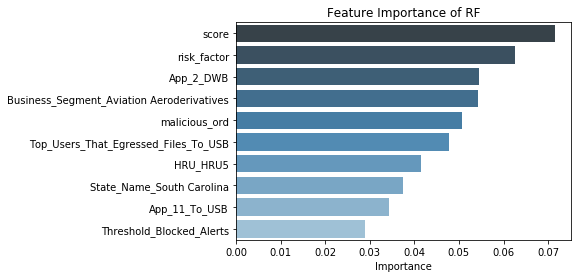

In [55]:
df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['Importance'])
df_rt = df[:10]
sns.barplot(x='Importance', y=df_rt.index, data=df_rt,
             palette="Blues_d")
plt.title('Feature Importance of RF')